In [1]:
import h5py
import pylab as pl
import numpy as np
import matplotlib.colors as mpc
import networkx
import ipyvolume as ipv
import progressbar
import astropy.cosmology as apc

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [3]:
pl.rc('font', size = 30)
pl.rc('legend', fontsize = 30)
pl.rc('axes', linewidth=1.5)

In [4]:
# sim = h5py.File('/data/cielo/simulations/LG1/LG1.hdf5', 'r')
# trees = networkx.read_multiline_adjlist('/data/cielo/simulations/LG1/LG1_tree.dat')
#sim = h5py.File('/disk1/data1-casona/data1/cielo/simulations/LG1/LG1.hdf5', 'r')
#trees = networkx.read_multiline_adjlist('/disk1/data1-casona/data1/cielo/simulations/LG1/LG1_tree.dat')
sim = h5py.File('/disk1/lbignone/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/disk1/lbignone/data/cielo/simulations/LG1/LG1_tree.dat')

In [5]:
# ok, lets determine the orbital plane for one galaxy, 
ff, cc = 4474, 4469
uniqueID = int(128*1e6+ff)
stree = networkx.dfs_tree(trees, str(uniqueID))
mtree = get_main_branch_unique_ids(stree, str(uniqueID))

uniqueC = int(128*1e6+cc)
streeC = networkx.dfs_tree(trees, str(uniqueC))
mtreeC = get_main_branch_unique_ids(streeC, str(uniqueC))

x, y, z = [], [], []
for m, mC in zip(mtree, mtreeC):
    snap, ffT = split_unique_id(int(m))
    snapC, ccT = split_unique_id(int(mC))
    if snap == snapC:
        posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][ffT]
        posCen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][ccT]
        pGal = posGal-posCen
        x.append(pGal[0])
        y.append(pGal[1])
        z.append(pGal[2])
        
x, y, z = np.array(x), np.array(y), np.array(z)

In [6]:
ipv.figure(width=750, height=750)

ipv.plot(x, y, z, ls='-')

ipv.show()

In [7]:
# and by putting size by lost gas mass

def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

def get_main_branch_and_progNumb(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    numb = [[node], ]
    i = 0
    while True:
        successors = list(subtree.successors(node))
        if len(successors) == 0:
            break
        node = successors[0] # select only the first succesor (main branch)
        mpb.append(node)
        numb.append(successors)
        
    return mpb, numb


def set_view(figure, framenr, fraction):
    ipv.view(fraction*360, 0.)
    
def set_angles(fig, i, fraction):
    fig.angley = fraction*np.pi*2

# a bunch of constants
UnitMass_in_g = 1.989e+43
UnitTime_in_s = 3.08568e+16
UnitVelocity_in_cm_per_s = 100000
UnitDensity_in_cgs = 6.7699e-22
UnitEnergy_in_cgs = 1.989e+53
GAMMA_MINUS1 = 2./3.
PROTONMASS = 1.6726e-24
BOLTZMANN = 1.3806e-16    

def tempFromMass(Mass, Abund, IE, ne1):
    XH = Abund[:,6]/Mass
    yHelium = (1. - XH)/(4.*XH)
    mu = (1 + 4.* yHelium)/ (1.+ yHelium + ne1 )
    temp = GAMMA_MINUS1 * IE * mu * 1.6726 / 1.3806 * 1.e-8 # / BOLTZMANN  * PROTONMASS
    temp = temp * 1e10 #   UnitEnergy_in_cgs / UnitMass_in_g;
    return temp



def plotPhaseSpace(fofID, centralID):
    uniqueID = int(128*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree, numbs = get_main_branch_and_progNumb(stree, str(uniqueID))
    
    uniqueC = int(128*1e6+centralID)
    streeC = networkx.dfs_tree(trees, str(uniqueC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueC))
    
    # find all the particleIDs that once belong to the subgroup
#     Idlist, vallist, valcen = [], [], []
    Idlist, vallist = [], []
    
    for mm, mmC in zip(mtree[1:], mtreeC[1:]): # ignore the first one
        snap, idd = split_unique_id(int(mm))
        snapC, iddC = split_unique_id(int(mmC))
        tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        pgal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
        if snapC==snap:
            pcen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapC)][iddC]
        if tempOff[0]>= 0 and tempOff[1]>=0:
            tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
            Idlist.extend(list(tempIds))
            # calcule the value for color coding the graph
            #val = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
            val = snap # eso
            #IE = sim['SnapNumber_{}/PartType0/InternalEnergy'.format(snap)][tempOff[0]:tempOff[1]]
            #Mass = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][tempOff[0]:tempOff[1]]
            #Abund = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][tempOff[0]:tempOff[1]]
            #ne1 = sim['SnapNumber_{}/PartType0/ElectronAbundance'.format(snap)][tempOff[0]:tempOff[1]]
            #val = tempFromMass(Mass, Abund, IE, ne1)
            #val = sim['SnapNumber_{}/PartType0/BindingEnergy'.format(snap)][tempOff[0]:tempOff[1]]
            #val, othi = getAnglesTime(idd, iddC, snap)
            #othi, val = getAnglesTime(idd, iddC, snap)
            #val = np.abs(val)
            #L = sim['SnapNumber_{}/PartType0/SpecificAngularMomentum'.format(snap)][tempOff[0]:tempOff[1]]
            #Lt = np.sqrt(L[:,0]**2+L[:,1]**2+L[:,2]**2)
            #val = L[:,2]/Lt # Lz
            #return None
            # if val is one for each particles just append, otherwise do the next
            vallist.extend([val]*tempIds.size)
            # or
            #vallist.extend(list(val))

    Idlist, vallist = np.array(Idlist), np.array(vallist)
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    vallist = vallist[Idunique]

    # the total list of particles that once belong to a give subgroup, lest see where are today.
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][fofID].astype('int')
    TdayCoord = sim['SnapNumber_128/PartType0/Coordinates'][TdayOff[0]:TdayOff[1]]

    TdayTotalIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][()]
    
    IndexToday = np.in1d(TdayTotalIDs, Idlist)
    IndexToday_ = np.where(IndexToday)[0]
    
    #remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    LostCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_]
    
    # ... and the redshift
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    vallist_, Idlist_ = vallist[iidex_], Idlist[iidex_]

    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    valorder = np.zeros(IndexT_.size)
    valorder[is1] = vallist_[is2]
    
    #now lets cut at  a certain distance
    distance = 600 # distance in ckpc

    posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][centralID]

    dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
    distToC = np.sqrt(dx**2+dy**2+dz**2)

    icut = np.where(distToC<distance)[0]
    IndexT_near = IndexT_[icut]
    valorder_near = valorder[icut]
    #IndexT_near = IndexT_
    #valorder_near = valorder
    
    #NearCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_near]
    #NearVel = sim['SnapNumber_128/PartType0/Velocities'][IndexT_near]
    NearMass = sim['SnapNumber_128/PartType0/Masses'][IndexT_near]
    
    # here i make the cut.
    return NearMass, valorder_near

In [8]:
def getVec(gal, centre, snap):
    velC = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(snap)][gal]
    posC = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][gal]
    offs = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][gal].astype('int')

    
#     print('nstars:',offs[1]-offs[0])
    a = sim['SnapNumber_{}/Header/Time'.format(snap)][()]

    posStars = sim['SnapNumber_{}/PartType4/Coordinates'.format(snap)][offs[0]:offs[1]]
    velStars = sim['SnapNumber_{}/PartType4/Velocities'.format(snap)][offs[0]:offs[1]]
    velStars = np.sqrt(a)*velStars

    Mass = sim['SnapNumber_{}/PartType4/Masses'.format(snap)][offs[0]:offs[1]]

    orad = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][gal]

    x, y, z = posStars[:,0] - posC[0], posStars[:,1] - posC[1], posStars[:,2] - posC[2]
    r = np.sqrt(x**2+y**2+z**2)
    ir = np.where(r<orad)[0]

    x, y, z = x[ir], y[ir], z[ir]

    velStars = velStars[ir]
    vx, vy, vz = velStars[:,0] - velC[0], velStars[:,1] - velC[1], velStars[:,2] - velC[2]

    Mass = Mass[ir]

    Lx, Ly, Lz = [], [], []

    for xi, yi, zi, vxi, vyi, vzi in zip(x, y, z, vx, vy, vz):
        rp = np.array([xi, yi, zi])
        rv = np.array([vxi, vyi, vzi])
        l = np.cross(rp, rv)
        Lx.append(l[0])
        Ly.append(l[1])
        Lz.append(l[2])

    Lx, Ly, Lz = np.array(Lx), np.array(Ly), np.array(Lz)

    Ltot = np.array([np.sum(Mass*Lx), np.sum(Mass*Ly), np.sum(Mass*Lz)])
    Lnorm = Ltot/np.sqrt(np.sum(Ltot**2.))

    ipro = []
    ii = 0
    for lx, ly, lz in zip(Lx, Ly, Lz):
        lnormi = np.array([lx, ly, lz])/np.sqrt(lx**2+ly**2+lz**2) 
        ddot = np.dot(lnormi, Lnorm)
        if ddot>0:
            ipro.append(ii)
        ii += 1

    Ltot = np.array([np.sum(Mass[ipro]*Lx[ipro]), np.sum(Mass[ipro]*Ly[ipro]), np.sum(Mass[ipro]*Lz[ipro])])
    Lnorm = Ltot/np.sqrt(np.sum(Ltot**2.))
    
    return Lnorm, Ltot


def getAnglesTime(gal, centre, snap):
    offGas = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][gal].astype('int')
#     RotMass = sim['SnapNumber_{}/SubGroups/PartType4/RotationMatrix'.format(snap)][gal]
    cenGas = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][gal]
#     RotII = RotMass.T
#     R = np.array([0., 0., 1.])
#     R_rot = np.dot(RotII, R.T).T
    R_rot, LzM = getVec(gal, centre, snap)
    
    velGal = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(snap)][gal]
    cenGro = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][centre]
    velGro = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(snap)][centre]
    
    vecCen = cenGro - cenGas
    vecVel = velGal - velGro
    
    x, y, z = cenGas[0]-cenGro[0], cenGas[1]-cenGro[1], cenGas[2]-cenGro[2]
    
    sep = np.sqrt(np.sum(vecCen**2))
    
    gro = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][centre]
    R200 = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][gro]
    
    sepr200 = sep/R200
    
    vecCenN = vecCen/sep
    vecVelN = vecVel/np.sqrt(np.sum(vecVel**2.))
    
    # and cosines
    cosCen = np.dot(R_rot, vecCenN)
    cosVel = np.dot(R_rot, vecVelN)
    
#     Ls = sim['SnapNumber_{}/PartType4/SpecificAngularMomentum'.format(snap)][offGas[0]:offGas[1]]
#     Lz = Ls[:,2]
#     L = np.sqrt(Ls[:,0]**2+Ls[:,1]**2+Ls[:,2]**2)
#     LzL = Lz/L
    
#     ii = np.where(np.isnan(LzL)==False)
#     LzL = LzL[ii]
    
#     LzM = np.mean(LzL)
    
    return R_rot, LzM, sepr200, x, y, z, cosVel

# the new one, just the part that do not work




def getTime_withMass(ff, cc, number=100):
    uniqueID = int(128*1e6+ff)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    # and the centre
    uniqueIDC = int(128*1e6+cc)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
    VecRot, LZ, dist = [], [], []
    z, snaplist, mass = [], [], []
    X, Y, Z = [], [], []
    LostMasses, snapMasses = plotPhaseSpace(ff, cc) # all masses at all z.
    cV = []
    for mm, mmC in zip(mtree, mtreeC):
        snap, ffT = split_unique_id(int(mm))
        snapC, ccT = split_unique_id(int(mmC))
        if snap==snapC:
            Off = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][ffT].astype('int')
            Np = Off[1]-Off[0]
            if Np>number:
                # and masses
                imasses = np.where(snapMasses==snap)
                ThisMasses = LostMasses[imasses]
                sMass = np.sum(ThisMasses)
                mass.append(sMass)
                
                R_rot, LzT, distT, xt, yt, zt, cosVel = getAnglesTime(ffT, ccT, snap)
                VecRot.append(R_rot)
                LZ.append(LzT)
                dist.append(distT)
                zi = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
                z.append(zi)
                snaplist.append(snap)
                X.append(xt)
                Y.append(yt)
                Z.append(zt)
                cV.append(cosVel)

    VecRot, LZ, dist = np.array(VecRot), np.array(LZ), np.array(dist)
    z, snaplist = np.array(z), np.array(snaplist)
    mass = np.array(mass)
    X, Y, Z = np.array(X), np.array(Y), np.array(Z)
    cV = np.array(cV)
    
    return VecRot, LZ, dist, z, snaplist, mass, X, Y, Z, cV

In [9]:
vecRot, LZ, dist, redshift, snaplist, mass, X, Y, Z, cV = getTime_withMass(ff, cc, number=1000)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


In [10]:
gro = sim['SnapNumber_128/SubGroups/GroupNumber'][cc]
R200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][gro]


acV = np.abs(cV)

i1 = np.where(dist<2.)
acVM = np.median(acV[i1])

print(acVM, np.arccos(acVM)*180/np.pi)

ic1 = np.where((acV<acVM) & (dist<2.))
ic2 = np.where((acV>acVM) & (dist<2.))

print(np.mean(mass[ic2]), np.mean(mass[ic1]), np.mean(mass[ic2])/np.mean(mass[ic1]))


0.69174033 46.231969303023455
0.0036352186 0.0035637713 1.0200483


In [11]:
ipv.figure(width=750, height=750)

ipv.plot(X, Y, Z, ls='-')

ipv.show()

In [12]:
group = sim['SnapNumber_128/SubGroups/GroupNumber'][cc]
R200 =  sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

d = np.sqrt(X**2+Y**2+Z**2)

i = np.where(d<3.*R200)
Xi, Yi, Zi = X[i], Y[i], Z[i]

In [13]:
# ipv.figure(width=750, height=750)

# ipv.plot(Xi, Yi, Zi, ls='-')

# ipv.show()

In [14]:
# now i need to determine the plane and the rotation to get to this plane.
# firt we need the perithing
# imin = np.where(d==d.min())[0][0]
imin = 0 # at z=0

mtreei, mtreeCi = mtree[imin], mtreeC[imin]
snapT, ffT = split_unique_id(int(mtreei))
snapTC, ccT = split_unique_id(int(mtreeCi))

velGal = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(snapT)][ffT]
velCen = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(snapTC)][ccT]

vel = velGal- velCen
pos = np.array([Xi[imin], Yi[imin], Zi[imin]])

In [15]:
h = np.cross(pos, vel)
h = h/np.sqrt(np.sum(h**2.))

In [16]:
f = (1-h[0])/(h[1]**2 + h[2]**2)
R1 = np.array([[0, h[1], h[2]], [-h[1], 0, 0], [-h[2], 0, 0]])
R2 = np.matmul(R1, R1)

RM = np.identity(3) + R1 + R2*f

inc = np.arccos(h[2])

#RM = np.array([[1, 0, 0], [0, np.cos(inc), np.sin(inc)], [0, -np.sin(inc), np.cos(inc)] ])

In [17]:
Xr, Yr, Zr = [], [], []

for x, y, z in zip(Xi, Yi, Zi):
    dV = np.matmul(RM, np.array([x, y, z]))
       
    Xr.append(dV[0])
    Yr.append(dV[1])
    Zr.append(dV[2])
    
Xr, Yr, Zr = np.array(Xr), np.array(Yr), np.array(Zr)

In [18]:
ipv.figure(width=750, height=750)

ipv.plot(Xr, Yr, Zr, ls='-')
ipv.xlim(-400,200)
ipv.ylim(-400,200)
ipv.zlim(-400,200)

ipv.show()

In [19]:
ipv.figure(width=750, height=750)

ipv.plot(Xi, Yi, Zi, ls='-')

zero = np.array([0.])
ipv.quiver(zero, zero, zero, np.array([pos[0]]), np.array([pos[1]]), np.array([pos[2]]), color='black')
ipv.quiver(np.array([pos[0]]), np.array([pos[1]]), np.array([pos[2]]),np.array([vel[0]]), np.array([vel[1]]), np.array([vel[2]]), color='red')
ipv.quiver(np.array([pos[0]]), np.array([pos[1]]), np.array([pos[2]]),np.array([h[0]]), np.array([h[1]]), np.array([h[2]]), color='green')

ipv.xlim(-400,200)
ipv.ylim(-400,200)
ipv.zlim(-400,200)

ipv.show()

In [20]:
Xi[-1], Yi[-1], Zi[-1]

(-234.4336, -189.11719, -270.8047)

In [21]:
np.sqrt(Xi**2+Yi**2+Zi**2) - np.sqrt(Xr**2+Yr**2+Zr**2)

array([-2.92501376e-06, -2.92501376e-06, -3.16811229e-06, -3.50238059e-06,
       -6.13189513e-07, -8.76508285e-06, -1.02349477e-05, -8.04328195e-07,
       -1.39486658e-05, -3.63367630e-06, -5.76840341e-06, -2.72636069e-06,
       -2.06782357e-05, -1.08887179e-05, -6.64044526e-06, -2.83158556e-07,
       -9.76794192e-06, -5.78863734e-07,  1.20600367e-06, -1.39531830e-05,
       -1.34761724e-06, -3.84970157e-06, -2.84157284e-06, -2.15569531e-06,
       -4.79657558e-08, -4.85554563e-06, -1.32218686e-05, -4.63501644e-06,
       -6.61477597e-06, -7.63899422e-06, -8.18234349e-06, -8.65636611e-06,
       -9.18925042e-06, -2.59762034e-05, -4.71715396e-07, -8.79018421e-06,
       -8.94496105e-06,  6.54915027e-07, -4.82347042e-06, -1.99322321e-05,
        4.13563521e-06, -1.27062614e-05, -1.84836504e-05, -1.74785827e-05,
       -1.97626760e-05, -1.17504914e-05, -1.68845447e-05, -2.21096050e-05,
       -1.76868826e-05, -9.01720750e-06, -8.15821414e-06, -2.34229204e-05,
       -1.94563411e-05, -

(-400.0, 300.0)

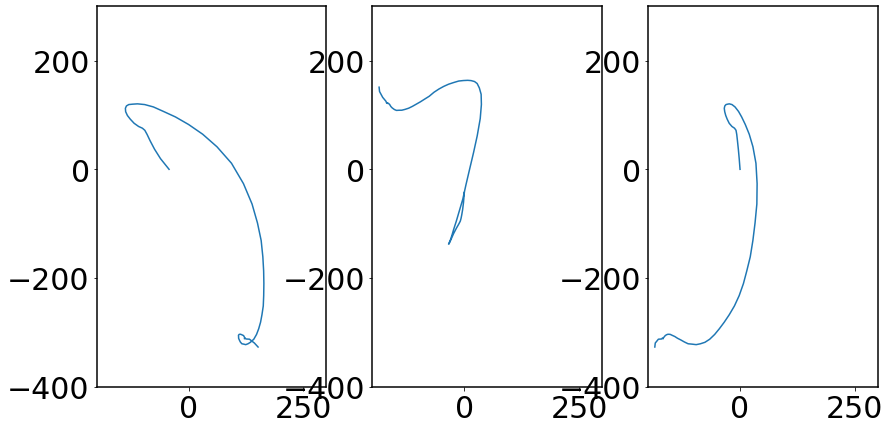

In [22]:
pl.figure(figsize=(14, 7))

pl.subplot(1, 3, 1)
pl.plot(Yr, Zr)
pl.xlim((-200,300))
pl.ylim((-400,300))

pl.subplot(1, 3, 2)
pl.plot(Xr, Yr)
pl.xlim((-200,300))
pl.ylim((-400,300))

pl.subplot(1, 3, 3)
pl.plot(Xr, Zr)
pl.xlim((-200,300))
pl.ylim((-400,300))

In [23]:
OmegaM = sim['SnapNumber_128/Header/Omega0'][()]
Cosmo = apc.FlatLambdaCDM(H0=100, Om0=OmegaM) # H0 = 100, so all quantities are in h or /h

In [24]:
redshifti, massi = redshift[i], mass[i]
time = Cosmo.lookback_time(redshifti).value

In [25]:
def getVirZ(z, dist, distat=2):
    i1 = np.where(dist<distat)
    zin = z[i1]
    zenter = zin.max() # yeap, this is
    tenter = Cosmo.lookback_time(zenter).value
    return zenter, tenter

In [26]:
zin, tin = getVirZ(redshift, dist[i], distat=2)

In [27]:
# timein = tin - time
timein = time
mass.shape, Yr.shape, Zr.shape

((78,), (61,), (61,))

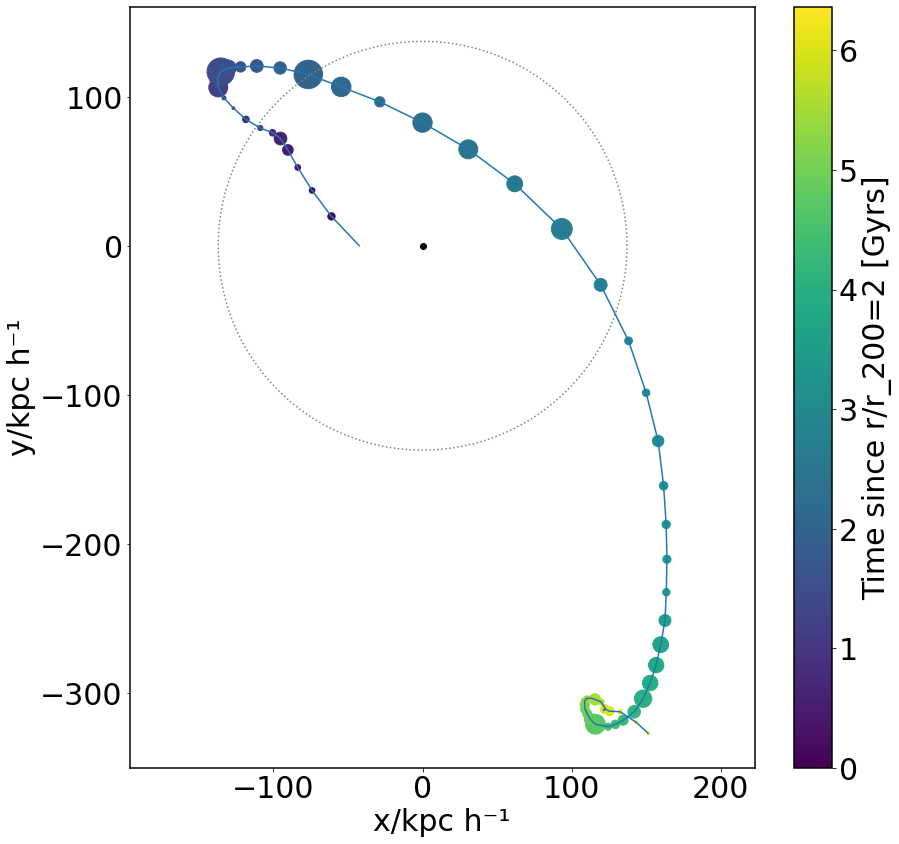

In [28]:
pl.figure(figsize=(14, 14))

tr200 = np.linspace(0, 2*np.pi, 360)
xr200, yr200 = R200*np.cos(tr200), R200*np.sin(tr200)

pl.plot(Yr, Zr)

pl.scatter(Yr, Zr, c=timein, s=mass[i]*50000)
#pl.scatter(0., 0., color='black')

pl.plot(xr200, yr200, ls=':', color='grey')
pl.plot(0, 0,  marker='o', ls=' ', color='black')

pl.xlabel('x/kpc h⁻¹')
pl.ylabel('y/kpc h⁻¹')

pl.axis('equal')
pl.colorbar(label='Time since r/r_200=2 [Gyrs]')

In [29]:
# lets test te inclination of the stuff
import matplotlib.patches as mpatches
import matplotlib.cm as mpc

In [30]:
# firts, rotated vector is needed
vecRoti = vecRot[i]

VecRotR = []

for v in vecRoti:
    dV = np.matmul(RM, v)
       
    VecRotR.append(dV)
    
VecRotR = np.array(VecRotR)

In [31]:
# ok, the vector against the plane at each snapshot.

VecRotRSnap = []

for v, mm, mmC in zip(vecRoti, mtree, mtreeC):
    snapTemp, ffTemp = split_unique_id(int(mm))
    snapTempC, ccTemp = split_unique_id(int(mmC))
    
    galC = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapTempC)][ffTemp]
    cenC = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapTempC)][ccTemp]
    
    velGT = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(snapTempC)][ffTemp]
    velCT = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(snapTempC)][ccTemp]
    
    posT = galC - cenC
    velT = velGT - velCT
    
    hT = np.cross(posT, velT)
    hT = hT/np.sqrt(np.sum(hT**2.))

    fT = (1-hT[0])/(hT[1]**2 + hT[2]**2)
    R1T = np.array([[0, hT[1], hT[2]], [-hT[1], 0, 0], [-hT[2], 0, 0]])
    R2T = np.matmul(R1T, R1T)

    RMT = np.identity(3) + R1T + R2T*fT
    
    # and now we rotate
    
    dVT = np.matmul(RMT, v)
       
    VecRotRSnap.append(dVT)
    
VecRotRSnap = np.array(VecRotRSnap)

xvS, yvS, zvS = VecRotRSnap[:,0], VecRotRSnap[:,1], VecRotRSnap[:,2]

baSnap = np.abs(xvS)
phiSnap = 90.- np.arctan2(zvS, yvS)*180./np.pi

In [32]:
xv, yv, zv = VecRotR[:,0], VecRotR[:,1], VecRotR[:,2]

In [33]:
# so, this is normalized, so., i need two thing, the b/a (the cos respect to the plane)
ba = np.abs(xv)
phi = 90.- np.arctan2(zv, yv)*180./np.pi

Text(-140.26216760060976, -299.1111719469721, 'g4474')

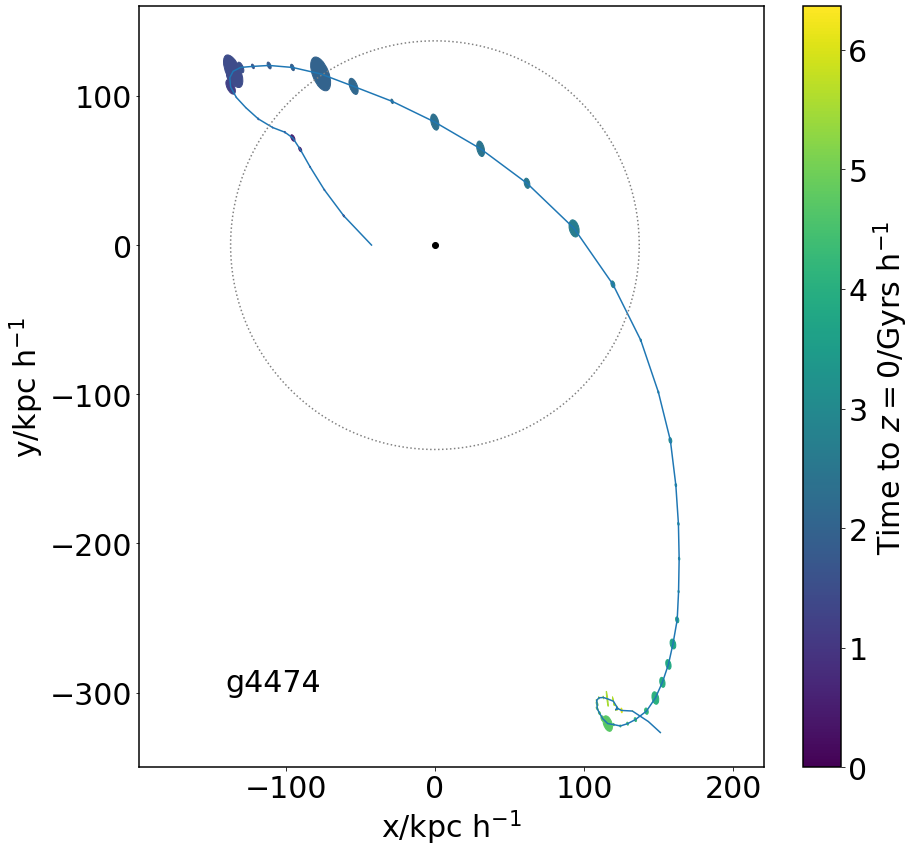

In [34]:
# so, lets plot this thing
#pl.figure(figsize=(14, 14))
fig, ax = pl.subplots(figsize=(14,14))

tr200 = np.linspace(0, 2*np.pi, 360)
xr200, yr200 = R200*np.cos(tr200), R200*np.sin(tr200)

pl.plot(Yr, Zr)

cmap = mpc.viridis
norm = pl.Normalize(timein.min(), timein.max())

for x, y, massi, bai, phii, timeii in zip(Yr, Zr, mass, ba, phi, timein):
    a = np.sqrt(1./bai)*massi*1000
    b = np.sqrt(bai)*massi*1000
    
    Gal = mpatches.Ellipse((x, y), a, b, angle=phii, color=cmap(norm(timeii)))
    ax.add_patch(Gal)

#pl.scatter(Yr, Zr, c=timein, s=mass*50000)
#pl.scatter(0., 0., color='black')

pl.plot(xr200, yr200, ls=':', color='grey')
pl.plot(0, 0,  marker='o', ls=' ', color='black')

pl.xlabel('x/kpc h$^{-1}$')
pl.ylabel('y/kpc h$^{-1}$')

pl.axis('equal')
pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='Time to $z=0$/Gyrs h$^{-1}$', )

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[0]+deltay/10., 'g{}'.format(ff))

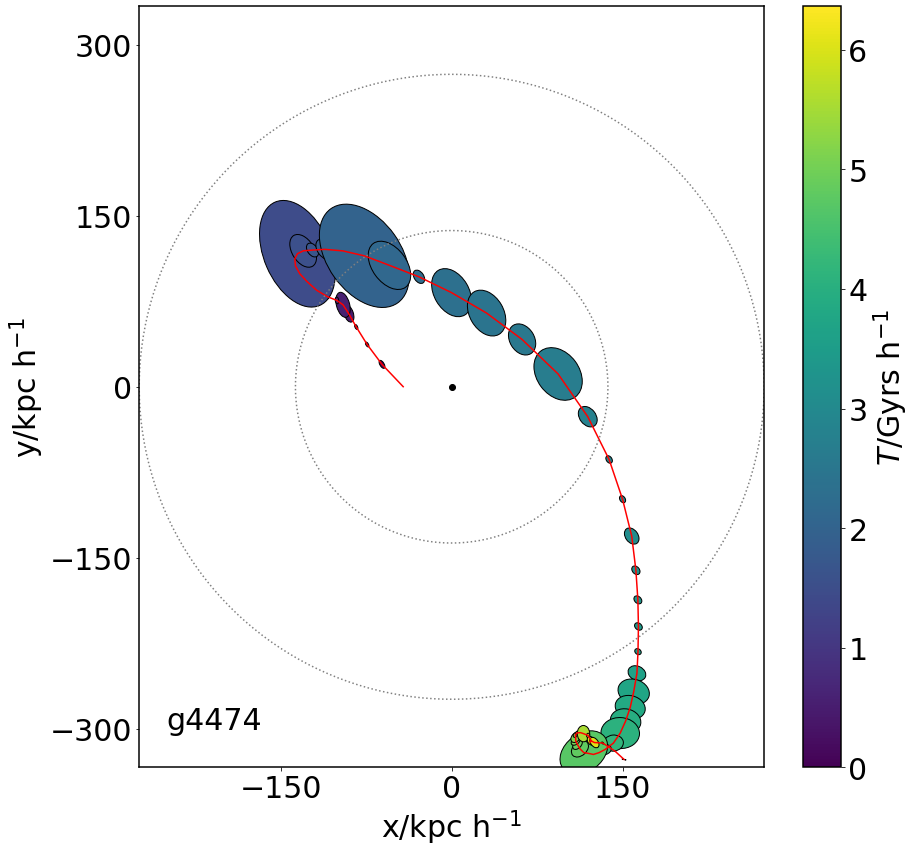

In [68]:
# aaand the same, bt for the other plane, still not sure about the phi, though
#pl.figure(figsize=(14, 14))
fig, ax = pl.subplots(figsize=(14,14))

tr200 = np.linspace(0, 2*np.pi, 360)
xr200, yr200 = R200*np.cos(tr200), R200*np.sin(tr200)

pl.plot(Yr, Zr, color='red')

cmap = mpc.viridis
norm = pl.Normalize(timein.min(), timein.max())

for x, y, massi, bai, phii, timeii in zip(Yr, Zr, mass, baSnap, phiSnap, timein):
    a = np.sqrt(1./bai)*massi*5000
    b = np.sqrt(bai)*massi*5000
    
    Gal = mpatches.Ellipse((x, y), a, b, angle=phii, color=cmap(norm(timeii)), ec='black')
    ax.add_patch(Gal)

#pl.scatter(Yr, Zr, c=timein, s=mass*50000)
#pl.scatter(0., 0., color='black')

pl.plot(xr200, yr200, ls=':', color='grey')
pl.plot(2.*xr200, 2.*yr200, ls=':', color='grey')
pl.plot(0, 0,  marker='o', ls=' ', color='black')

pl.xlabel('x/kpc h$^{-1}$')
pl.ylabel('y/kpc h$^{-1}$')

pl.axis('equal')
pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='$T$/Gyrs h$^{-1}$', )

if cc==4337:
    pl.xticks((-400,-200,0,200,400))
    pl.yticks((-400,-200,0,200,400))
    pl.text(-300, -350, 'g{}'.format(ff))
    pl.ylim([-405, 405])
    pl.xlim([-2.*R200,2*R200])
else:
    pl.xticks((-300,-150,0,150,300))
    pl.yticks((-300,-150,0,150,300))
    pl.text(-250, -300, 'g{}'.format(ff))
    pl.ylim([-305, 305])
    pl.xlim([-2.*R200,2*R200])

xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

# pl.text(xlim[0]+deltax/20., ylim[0]+deltay/10., 'g{}'.format(ff))

In [69]:
ba, baSnap

(array([0.44188507, 0.44192045, 0.44160291, 0.43806035, 0.44322776,
        0.47147681, 0.47064855, 0.47928755, 0.47691916, 0.46668208,
        0.45549147, 0.48545135, 0.458482  , 0.43096057, 0.42061631,
        0.42624303, 0.45163901, 0.44885116, 0.44156289, 0.45469508,
        0.44572087, 0.44892664, 0.45569546, 0.4611737 , 0.52449667,
        0.54452763, 0.51770512, 0.47708114, 0.46421594, 0.48409259,
        0.5013751 , 0.48306199, 0.48656953, 0.49721917, 0.51074262,
        0.53676758, 0.50637106, 0.49774757, 0.51265432, 0.53995722,
        0.54624539, 0.49586737, 0.49049906, 0.56210831, 0.51611627,
        0.52406677, 0.52963281, 0.37249938, 0.34842077, 0.35591368,
        0.13733762, 0.07661044, 0.05938942, 0.01195565, 0.18025487,
        0.29038245, 0.25766506, 0.26824729, 0.32173999, 0.52594313,
        0.36173982]),
 array([0.44188507, 0.44186665, 0.46506303, 0.47679023, 0.49190839,
        0.51541721, 0.50980952, 0.51083398, 0.54766319, 0.56439044,
        0.55960755, 0.5898

In [37]:
#pl.colorbar?

In [38]:
# from sphviewer.tools import QuickView

In [39]:
# DMParts = sim['SnapNumber_128/PartType1/Coordinates'][()]
# cen = sim['SnapNumber_128/SubGroups/SubGroupPos'][cc]

# Xd, Yd, Zd = DMParts[:,0]-cen[0], DMParts[:,1]-cen[1], DMParts[:,2]-cen[2]
# RR = np.sqrt(Xd**2+Yd**2+Zd**2)

# i = np.where(RR<=3.*R200)

# newP = np.array([Xd[i], Yd[i], Zd[i]]).T

In [40]:
# qv = QuickView(newP, r='infinity', plot=False)
# qv.imshow(cmap='gist_gray')

In [41]:
# # and rotated, well, not yet, lets puts things in from of each other
# fig, ax = pl.subplots(figsize=(14,14))

# tr200 = np.linspace(0, 2*np.pi, 360)
# xr200, yr200 = R200*np.cos(tr200), R200*np.sin(tr200)

# pl.plot(Yr, Zr)

# cmap = mpc.viridis
# norm = pl.Normalize(timein.min(), timein.max())

# for x, y, massi, bai, phii, timeii in zip(Yr, Zr, mass, ba, phi, timein):
#     a = np.sqrt(1./bai)*massi*1000
#     b = np.sqrt(bai)*massi*1000
    
#     Gal = mpatches.Ellipse((x, y), a, b, angle=phii, color=cmap(norm(timeii)))
#     ax.add_patch(Gal)

# #pl.scatter(Yr, Zr, c=timein, s=mass*50000)
# #pl.scatter(0., 0., color='black')

# pl.plot(xr200, yr200, ls=':', color='grey')
# pl.plot(0, 0,  marker='o', ls=' ', color='black')

# pl.xlabel('x/kpc h⁻¹')
# pl.ylabel('y/kpc h⁻¹')

# pl.axis('equal')
# pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='Time since r/r_200=2 [Gyrs]')
# qv = QuickView(newP, r='infinity', plot=False)
# qv.imshow(cmap='gist_gray_r')

In [42]:
# # and now lets see if i can ratate the things, lets see
# newPR = []

# for v in newP:
#     dV = np.matmul(RM, v)
       
#     newPR.append(np.array([dV[1], dV[2], dV[0]])) # y, z, x
    
# newPR = np.array(newPR)

In [43]:
# # and rotated, well, not yet, lets puts things in from of each other
# fig, ax = pl.subplots(figsize=(14,14))

# tr200 = np.linspace(0, 2*np.pi, 360)
# xr200, yr200 = R200*np.cos(tr200), R200*np.sin(tr200)

# pl.plot(Yr, Zr)

# cmap = mpc.viridis
# norm = pl.Normalize(timein.min(), timein.max())

# for x, y, massi, bai, phii, timeii in zip(Yr, Zr, mass, ba, phi, timein):
#     a = np.sqrt(1./bai)*massi*7000
#     b = np.sqrt(bai)*massi*7000
    
#     Gal = mpatches.Ellipse((x, y), a, b, angle=phii, color=cmap(norm(timeii)))
#     ax.add_patch(Gal)

# #pl.scatter(Yr, Zr, c=timein, s=mass*50000)
# #pl.scatter(0., 0., color='black')

# pl.plot(xr200, yr200, ls=':', color='grey')
# pl.plot(0, 0,  marker='o', ls=' ', color='black')

# pl.xlabel('x/kpc h⁻¹')
# pl.ylabel('y/kpc h⁻¹')

# pl.axis('equal')
# pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='Time since r/r_200=2 [Gyrs]')
# qv = QuickView(newPR, r='infinity', plot=False)
# qv.imshow(cmap='gist_gray_r')

In [44]:
# uniqueIDC = int(128*1e6+cc)
# streeC = networkx.dfs_tree(trees, str(uniqueIDC))
# mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))

In [45]:
# I = 10 # any

# snapT, ccT = split_unique_id(int(mtreeC[I]))

# DMParts_snap = sim['SnapNumber_{}/PartType1/Coordinates'.format(snapT)][()]
# cen_snap = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapT)][ccT]

# Xd_snap, Yd_snap, Zd_snap = DMParts_snap[:,0]-cen_snap[0], DMParts_snap[:,1]-cen_snap[1], DMParts_snap[:,2]-cen_snap[2]
# RR_snap = np.sqrt(Xd_snap**2+Yd_snap**2+Zd_snap**2)

# i = np.where(RR_snap<=3.*R200) # lets use the z=0, to mantain th size

# newP_snap = np.array([Xd_snap[i], Yd_snap[i], Zd_snap[i]]).T

# newPR_snap = []

# for v in newP_snap:
#     dV = np.matmul(RM, v)
       
#     newPR_snap.append(np.array([dV[1], dV[2], dV[0]])) # y, z, x
    
# newPR_snap = np.array(newPR_snap)

In [46]:
# fig, ax = pl.subplots(figsize=(14,14))

# tr200 = np.linspace(0, 2*np.pi, 360)
# xr200, yr200 = R200*np.cos(tr200), R200*np.sin(tr200)

# pl.plot(Yr, Zr)

# cmap = mpc.viridis
# norm = pl.Normalize(timein.min(), timein.max())

# a = np.sqrt(1./ba[I])*mass[I]*2000
# b = np.sqrt(ba[I])*mass[I]*2000
    
# Gal = mpatches.Ellipse((Yr[I], Zr[I]), a, b, angle=phi[I], color=cmap(norm(timein[I])))
# ax.add_patch(Gal)

# pl.plot(xr200, yr200, ls=':', color='grey')
# pl.plot(0, 0,  marker='o', ls=' ', color='black')

# pl.xlabel('x/kpc h⁻¹')
# pl.ylabel('y/kpc h⁻¹')

# pl.axis('equal')
# pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='Time since r/r_200=2 [Gyrs]')
# qv = QuickView(newPR_snap, r='infinity', plot=False)
# qv.imshow(cmap='gist_gray_r')

# fig.savefig('density_4338/test2.png')
# pl.close(fig)

In [47]:
# # for each of this

# II = np.arange(Yr.size)

# pl.ioff()

In [48]:
# for I in II:
#     snapT, ccT = split_unique_id(int(mtreeC[I]))

#     DMParts_snap = sim['SnapNumber_{}/PartType0/Coordinates'.format(snapT)][()]
#     cen_snap = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapT)][ccT]

#     Xd_snap, Yd_snap, Zd_snap = DMParts_snap[:,0]-cen_snap[0], DMParts_snap[:,1]-cen_snap[1], DMParts_snap[:,2]-cen_snap[2]
#     RR_snap = np.sqrt(Xd_snap**2+Yd_snap**2+Zd_snap**2)

#     i = np.where(RR_snap<=3.5*R200) # lets use the z=0, to mantain th size

#     newP_snap = np.array([Xd_snap[i], Yd_snap[i], Zd_snap[i]]).T

#     newPR_snap = []

#     for v in newP_snap:
#         dV = np.matmul(RM, v)
       
#         newPR_snap.append(np.array([dV[1], dV[2], dV[0]])) # y, z, x
    
#     newPR_snap = np.array(newPR_snap)
    
#     fig, ax = pl.subplots(figsize=(14,14))

#     tr200 = np.linspace(0, 2*np.pi, 360)
#     xr200, yr200 = R200*np.cos(tr200), R200*np.sin(tr200)

#     pl.plot(Yr, Zr)

#     cmap = mpc.viridis
#     norm = pl.Normalize(timein.min(), timein.max())

#     a = np.sqrt(1./ba[I])*mass[I]*7000
#     b = np.sqrt(ba[I])*mass[I]*7000
    
#     Gal = mpatches.Ellipse((Yr[I], Zr[I]), a, b, angle=phi[I], color=cmap(norm(timein[I])))
#     ax.add_patch(Gal)

#     pl.plot(xr200, yr200, ls=':', color='grey')
#     pl.plot(0, 0,  marker='o', ls=' ', color='black')

#     pl.xlabel('x/kpc h⁻¹')
#     pl.ylabel('y/kpc h⁻¹')

#     pl.axis('equal')
#     pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='Time since r/r_200=2 [Gyrs]')
#     qv = QuickView(newPR_snap, r='infinity', plot=False)
#     qv.imshow(cmap='gist_gray_r')

#     fig.savefig('density_4341/Gas_{}.png'.format(str(I).zfill(2)))
#     pl.close(fig)
    

In [49]:
# str(9).zfill(2)

In [50]:
# # and rotated, well, not yet, lets puts things in from of each other
# fig, ax = pl.subplots(figsize=(14,14))

# tr200 = np.linspace(0, 2*np.pi, 360)
# xr200, yr200 = R200*np.cos(tr200), R200*np.sin(tr200)

# pl.plot(Yr, Zr)

# cmap = mpc.viridis
# norm = pl.Normalize(timein.min(), timein.max())

# for x, y, massi, bai, phii, timeii in zip(Yr, Zr, mass, ba, phi, timein):
#     a = 10
#     b = 10
    
#     Gal = mpatches.Ellipse((x, y), a, b, angle=phii, color='blue')
#     ax.add_patch(Gal)

# #pl.scatter(Yr, Zr, c=timein, s=mass*50000)
# #pl.scatter(0., 0., color='black')

# pl.plot(xr200, yr200, ls=':', color='grey')

# pl.xlabel('x/kpc h⁻¹')
# pl.ylabel('y/kpc h⁻¹')

# pl.axis('equal')
# pl.colorbar(mappable=mpc.ScalarMappable(norm=norm, cmap=cmap), label='Time since r/r_200=2 [Gyrs]')
# qv = QuickView(newPR, r='infinity', plot=False)
# qv.imshow(cmap='gist_gray_r')

In [51]:
# I = 10 # any

# snapT, ccT = split_unique_id(int(mtreeC[I]))

# DMParts_snap = sim['SnapNumber_{}/PartType1/Coordinates'.format(snapT)][()]
# GasParts_snap = sim['SnapNumber_{}/PartType0/Coordinates'.format(snapT)][()]

# cen_snap = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapT)][ccT]

# Xd_snap, Yd_snap, Zd_snap = DMParts_snap[:,0]-cen_snap[0], DMParts_snap[:,1]-cen_snap[1], DMParts_snap[:,2]-cen_snap[2]
# GXd_snap, GYd_snap, GZd_snap = GasParts_snap[:,0]-cen_snap[0], GasParts_snap[:,1]-cen_snap[1], GasParts_snap[:,2]-cen_snap[2]


# RR_snap = np.sqrt(Xd_snap**2+Yd_snap**2+Zd_snap**2)
# GRR_snap = np.sqrt(GXd_snap**2+GYd_snap**2+GZd_snap**2)

# i = np.where(RR_snap<=3.*R200) # lets use the z=0, to mantain th size
# iG = np.where(GRR_snap<=3.*R200)

# newP_snap = np.array([Xd_snap[i], Yd_snap[i], Zd_snap[i]]).T
# GnewP_snap = np.array([GXd_snap[iG], GYd_snap[iG], GZd_snap[iG]]).T

# newPR_snap = []
# GnewPR_snap = []

# for v in newP_snap:
#     dV = np.matmul(RM, v)
       
#     newPR_snap.append(np.array([dV[1], dV[2], dV[0]])) # y, z, x
    
# for gV in GnewP_snap:
#     GdV = np.matmul(RM, gV)
       
#     GnewPR_snap.append(np.array([GdV[1], GdV[2], GdV[0]]))
    
# newPR_snap = np.array(newPR_snap)
# GnewPR_snap = np.array(GnewPR_snap)

In [52]:
# from sphviewer.tools import Blend

# def get_normalized_image(image, vmin=None, vmax=None):
#     if(vmin == None):
#         vmin = np.min(image)
#     if(vmax == None):
#         vmax = np.max(image)

#     image = np.clip(image, vmin, vmax)
#     image = (image-vmin)/(vmax-vmin)

#     return image

In [53]:
# fig, ax = pl.subplots(figsize=(14,14))

# tr200 = np.linspace(0, 2*np.pi, 360)
# xr200, yr200 = R200*np.cos(tr200), R200*np.sin(tr200)

# pl.plot(Yr, Zr)

# ggray = mpc.gist_gray_r
# Greens = mpc.Greens

# a = 5
# b = 5
    
# Gal = mpatches.Ellipse((Yr[I], Zr[I]), a, b, angle=phi[I], color='red')
# ax.add_patch(Gal)

# pl.plot(xr200, yr200, ls=':', color='grey')

# pl.xlabel('x/kpc h⁻¹')
# pl.ylabel('y/kpc h⁻¹')


# qv = QuickView(newPR_snap, r='infinity', plot=False)
# img_qv  = qv.get_image()
# rgb_qv  = ggray(get_normalized_image(img_qv))

# Gqv = QuickView(GnewPR_snap, r='infinity', plot=False)
# img_Gqv = Gqv.get_image()
# rgb_Gqv  = Greens(get_normalized_image(img_Gqv))

# blend = Blend.Blend(rgb_qv, rgb_Gqv)
# rgb_output = blend.Overlay()

# pl.imshow(rgb_output, extent=(-3.*R200, 3.*R200, -3.*R200, 3.*R200), origin='lower')

In [54]:
# # ok, aparentley that works

# maxx = II.size

# for I in II:
    
#     snapT, ccT = split_unique_id(int(mtreeC[I]))

#     DMParts_snap = sim['SnapNumber_{}/PartType1/Coordinates'.format(snapT)][()]
#     GasParts_snap = sim['SnapNumber_{}/PartType0/Coordinates'.format(snapT)][()]

#     cen_snap = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapT)][ccT]

#     Xd_snap, Yd_snap, Zd_snap = DMParts_snap[:,0]-cen_snap[0], DMParts_snap[:,1]-cen_snap[1], DMParts_snap[:,2]-cen_snap[2]
#     GXd_snap, GYd_snap, GZd_snap = GasParts_snap[:,0]-cen_snap[0], GasParts_snap[:,1]-cen_snap[1], GasParts_snap[:,2]-cen_snap[2]


#     RR_snap = np.sqrt(Xd_snap**2+Yd_snap**2+Zd_snap**2)
#     GRR_snap = np.sqrt(GXd_snap**2+GYd_snap**2+GZd_snap**2)

#     i = np.where(RR_snap<=3.*R200) # lets use the z=0, to mantain th size
#     iG = np.where(GRR_snap<=3.*R200)

#     newP_snap = np.array([Xd_snap[i], Yd_snap[i], Zd_snap[i]]).T
#     GnewP_snap = np.array([GXd_snap[iG], GYd_snap[iG], GZd_snap[iG]]).T

#     newPR_snap = []
#     GnewPR_snap = []

#     for v in newP_snap:
#         dV = np.matmul(RM, v)
       
#         newPR_snap.append(np.array([dV[1], dV[2], dV[0]])) # y, z, x
    
#     for gV in GnewP_snap:
#         GdV = np.matmul(RM, gV)
       
#         GnewPR_snap.append(np.array([GdV[1], GdV[2], GdV[0]]))
    
#     newPR_snap = np.array(newPR_snap)
#     GnewPR_snap = np.array(GnewPR_snap)
    
#     fig, ax = pl.subplots(figsize=(14,14))

#     tr200 = np.linspace(0, 2*np.pi, 360)
#     xr200, yr200 = R200*np.cos(tr200), R200*np.sin(tr200)

#     pl.plot(Yr, Zr)

#     ggray = mpc.gist_gray_r
#     Greens = mpc.Greens

#     a = 5
#     b = 5
    
#     Gal = mpatches.Ellipse((Yr[I], Zr[I]), a, b, angle=phi[I], color='red')
#     ax.add_patch(Gal)

#     pl.plot(xr200, yr200, ls=':', color='grey')

#     pl.xlabel('x/kpc h⁻¹')
#     pl.ylabel('y/kpc h⁻¹')

#     qv = QuickView(newPR_snap, r='infinity', plot=False)
#     img_qv  = qv.get_image()
#     rgb_qv  = ggray(get_normalized_image(img_qv))

#     Gqv = QuickView(GnewPR_snap, r='infinity', plot=False)
#     img_Gqv = Gqv.get_image()
#     rgb_Gqv  = Greens(get_normalized_image(img_Gqv))

#     blend = Blend.Blend(rgb_qv, rgb_Gqv)
#     rgb_output = blend.Overlay()

#     pl.imshow(rgb_output, extent=(-3.*R200, 3.*R200, -3.*R200, 3.*R200), origin='lower')
    
#     fig.savefig('density_4474/DMGas_{}.png'.format(str(maxx-I).zfill(3)))
#     pl.close(fig)

In [55]:
# Ma = sim['SnapNumber_30/PartType0/Masses'][()]
# MaZ = sim['SnapNumber_128/PartType0/Masses'][()]

In [56]:
# np.mean(Ma), np.std(Ma)

In [57]:
# np.mean(MaZ), np.std(MaZ)

In [58]:
# sim['SnapNumber_30/Header/MassTable'][()]

In [59]:
# a1 = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][4337].astype('int')
# a2 = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][4469].astype('int')

In [60]:
# Ma1 = sim['SnapNumber_128/PartType4/Masses'][a1[0]:a1[1]]
# Ma2 = sim['SnapNumber_128/PartType4/Masses'][a2[0]:a2[1]]

In [61]:
# np.log10(np.sum(Ma1)*1e10), np.log10(np.sum(Ma2)*1e10)

In [62]:
# np.log10(np.mean(Ma)*1e10)

In [63]:
# np.log10(np.mean(MaZ)*1e10)

In [64]:
# xp1 = sim['SnapNumber_128/PartType4/Coordinates'][a1[0]:a1[1]]
# xc1 = sim['SnapNumber_128/SubGroups/SubGroupPos'][4337]
# ropt1 = sim['SnapNumber_128/SubGroups/OpticalRadius'][4337]

# x1, y1, z1 = xp1[:,0] - xc1[0], xp1[:,1] - xc1[1], xp1[:,2] - xc1[2]
# r1 = np.sqrt(x1**2+y1**2+z1**2)
# i1 = np.where(r1<ropt1)[0]
# np.log10(np.sum(Ma1[i1])*1e10)

In [65]:
# 10**10.52473600053361/10**10.605669811328204

In [66]:
# xp2 = sim['SnapNumber_128/PartType4/Coordinates'][a2[0]:a2[1]]
# xc2 = sim['SnapNumber_128/SubGroups/SubGroupPos'][4469]
# ropt2 = sim['SnapNumber_128/SubGroups/OpticalRadius'][4469]

# x2, y2, z2 = xp2[:,0] - xc2[0], xp2[:,1] - xc2[1], xp2[:,2] - xc2[2]
# r2 = np.sqrt(x2**2+y2**2+z2**2)
# i2 = np.where(r2<ropt2)[0]
# np.log10(np.sum(Ma2[i2])*1e10)